In [1]:
!pip install keras

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf


def get_session(gpu_fraction=0.9):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


ktf.set_session(get_session())

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
#from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications import NASNetMobile
#from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam as Adam

In [4]:
base_model=NASNetMobile(include_top=False, weights='../NASNet-mobile-no-top.h5', input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalizationV1) (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

adjust_bn_12 (BatchNormalizatio (None, 7, 7, 176)    704         adjust_conv_projection_12[0][0]  
__________________________________________________________________________________________________
normal_bn_1_12 (BatchNormalizat (None, 7, 7, 176)    704         normal_conv_1_12[0][0]           
__________________________________________________________________________________________________
activation_177 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_12[0][0]             
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 7, 7, 176)    0           adjust_bn_12[0][0]               
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 7, 7, 176)    0           adjust_bn_12[0][0]               
__________________________________________________________________________________________________
activation

In [5]:
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import Dropout
# model= Sequential()
# model.add(base_model)
# model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
# #model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.30))
# model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Dropout(0.30))
# model.add(Flatten())

# model.add(Dense(1, activation='sigmoid'))


In [6]:
#model.load_weights("../../ResNet50 Weights/ResNet50final11.hdf5")

In [7]:
from tensorflow.keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.2,  height_shift_range=0.2) 

In [8]:
train_data= train_generator.flow_from_directory(
                                                batch_size=256,directory="/raid/Data/Master_Dataset/elvin/final_mix/train/",
                                                shuffle=True,class_mode="binary",target_size=(224,224))

Found 948603 images belonging to 2 classes.


In [9]:
train_data.class_indices

{'fake': 0, 'real': 1}

In [10]:
test_generator=ImageDataGenerator(rescale = 1./255)

In [11]:
val_data= test_generator.flow_from_directory(
                                              directory="/raid/Data/Master_Dataset/elvin/final_mix/validation/",
                                              shuffle=True,batch_size=256,class_mode="binary",target_size=(224,224))

Found 518144 images belonging to 2 classes.


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=.5, min_lr=0.0001)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [14]:
from tensorflow.keras.utils import multi_gpu_model

In [15]:
# parallel_model = multi_gpu_model(model, gpus=3)
# parallel_model.compile(loss='binary_crossentropy',
#                            optimizer=Adam(lr=0.001),metrics=["accuracy"])
# #model.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])
# parallel_model.fit_generator(generator=train_data,
#                             steps_per_epoch=train_data.samples//train_data.batch_size,
#                             validation_data=val_data,
#                             verbose=1,
#                             validation_steps=val_data.samples//val_data.batch_size,
#                             epochs=3,callbacks=[learning_rate_reduction])

In [15]:
from matplotlib import pyplot
import sys

In [16]:
def summarize_diagnostics(history,epoch):
    # plot loss
    pyplot.subplot(121)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epochs')

    # plot accuracy
    pyplot.subplot(122)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    pyplot.ylabel('Accuracy')
    pyplot.xlabel('Epochs')

    pyplot.subplots_adjust(top=0.92, bottom=0.2, left=0.0, right=2.5, hspace=0.25,
                    wspace=0.25)
    pyplot.show()    


    #     pyplot.subplot(213)
    # 	pyplot.title('Classification Accuracy')
    # 	pyplot.plot(history.history['accuracy'], color='blue', label='train')
    # 	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename +'NasNet'+str(epoch)+ '_plot.png')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
2107/2107 [==============================] - 8502s 4s/step - loss: 0.1014 - acc: 0.9571 - val_loss: 1.5951 - val_acc: 0.7209
Epoch 2/2
2107/2107 [==============================] - 8606s 4s/step - loss: 0.0493 - acc: 0.9809 - val_loss: 0.8724 - val_acc: 0.8436


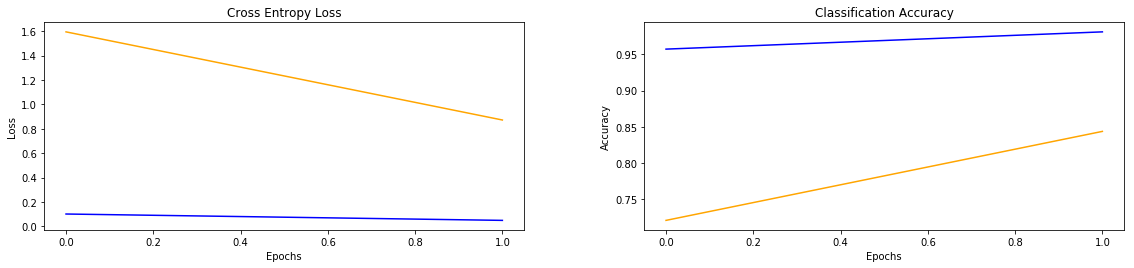

<Figure size 432x288 with 0 Axes>

In [16]:
from tensorflow.keras.utils import multi_gpu_model
#for y in [1,2,3,4,5,6,7,9,14]:
for y in [2]:
    try:
        location="BestWeights_epoch"+str(y)+ ".hdf5"
        #checkpointer = ModelCheckpoint(location, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        final_location=[]
        location=[]
        model= Sequential()
        model.add(base_model)
    # model.add(Conv2D(512, (3, 3), activation = 'relu'))

        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        #model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        #model.load_weights("../../ResNet50 Weights/ResNet50final11.hdf5")

    # model.add(Conv2D(512, (3, 3), activation = 'relu'))



        parallel_model = multi_gpu_model(model, gpus=2)
        parallel_model.compile(loss='binary_crossentropy',
                               optimizer=Adam(lr=0.001),metrics=["accuracy"])
    #model.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])
        history_model=parallel_model.fit_generator(generator=train_data,
                                steps_per_epoch=train_data.samples//train_data.batch_size,
                                validation_data=val_data,
                                verbose=1,
                                validation_steps=val_data.samples//val_data.batch_size,
                                epochs=y,callbacks=[learning_rate_reduction,es])

        model.save("NasNet"+str(y)+".hdf5")
        summarize_diagnostics(history_model,y)
        loss=history_model.history['loss']
        acc=history_model.history['acc']
        valacc=history_model.history['val_acc']
        valloss=history_model.history['val_loss']
        location = [y,loss,acc,valacc, valloss]
        final_location.append(location)
        save1 = pd.DataFrame(final_location,columns=['epochs','loss','acc','valacc','valloss'])
        save1.to_csv('NasNet'+str(y)+'.csv')
    except Exception as e: 
        print(e)
        continue
    


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/4
2024/2024 [==============================] - 2020s 998ms/step - loss: 8.0905 - acc: 0.4964

Epoch 00001: val_acc improved from -inf to 0.49642, saving model to BestWeights_epoch4.hdf5
3706/3706 [==============================] - 13669s 4s/step - loss: 0.1544 - acc: 0.9345 - val_loss: 8.0905 - val_acc: 0.4964
Epoch 2/4
2024/2024 [==============================] - 1948s 963ms/step - loss: 8.0305 - acc: 0.4971

Epoch 00002: val_acc improved from 0.49642 to 0.49710, saving model to BestWeights_epoch4.hdf5
3706/3706 [==============================] - 13528s 4s/step - loss: 0.0803 - acc: 0.9688 - val_loss: 8.0305 - val_acc: 0.4971
Epoch 3/4
2024/2024 [==============================] - 1968s 972ms/step - loss: 3.3457 - acc: 0.6922

Epoch 00003: val_acc improved from 0.49710 to 0.69223, saving model to BestWeights_epoch4.hdf5
3706/3706 [==============================] - 13334s 4s/step - loss: 0.0670 - acc: 0.9742 - val_loss: 3.3457 - val_acc: 0.6922
Epoch 4/4
2024/2024 [=============

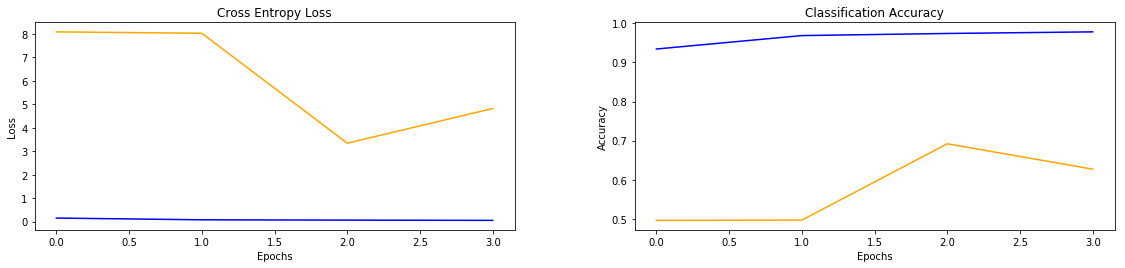

<Figure size 432x288 with 0 Axes>

In [18]:
from tensorflow.keras.utils import multi_gpu_model
#for y in [1,2,3,4,5,6,7,9,14]:
for y in [4]:
    try:
        location="BestWeights_epoch"+str(y)+ ".hdf5"
        checkpointer = ModelCheckpoint(location, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        final_location=[]
        location=[]
        model= Sequential()
        model.add(base_model)
    # model.add(Conv2D(512, (3, 3), activation = 'relu'))

        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        #model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        #model.load_weights("../../ResNet50 Weights/ResNet50final11.hdf5")

    # model.add(Conv2D(512, (3, 3), activation = 'relu'))



        #parallel_model = multi_gpu_model(model, gpus=2)
        model.compile(loss='binary_crossentropy',
                               optimizer=Adam(lr=0.001),metrics=["accuracy"])
    #model.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])
        history_model=model.fit_generator(generator=train_data,
                                steps_per_epoch=train_data.samples//train_data.batch_size,
                                validation_data=val_data,
                                verbose=1,
                                validation_steps=val_data.samples//val_data.batch_size,
                                epochs=y,callbacks=[learning_rate_reduction,es,checkpointer])

        model.save("NasNet"+str(y)+".hdf5")
        summarize_diagnostics(history_model,y)
        loss=history_model.history['loss']
        acc=history_model.history['acc']
        valacc=history_model.history['val_acc']
        valloss=history_model.history['val_loss']
        location = [y,loss,acc,valacc, valloss]
        final_location.append(location)
        save1 = pd.DataFrame(final_location,columns=['epochs','loss','acc','valacc','valloss'])
        save1.to_csv('NasNet'+str(y)+'.csv')
    except Exception as e: 
        print(e)
        continue

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
2024/2024 [==============================] - 2149s 1s/step - loss: 0.9619 - acc: 0.7056

Epoch 00001: val_acc improved from -inf to 0.70564, saving model to BestWeights_epoch6.hdf5
3706/3706 [==============================] - 13643s 4s/step - loss: 0.1569 - acc: 0.9350 - val_loss: 0.9619 - val_acc: 0.7056
Epoch 2/6
2024/2024 [==============================] - 1951s 964ms/step - loss: 0.9708 - acc: 0.8272

Epoch 00002: val_acc improved from 0.70564 to 0.82716, saving model to BestWeights_epoch6.hdf5
3706/3706 [==============================] - 13006s 4s/step - loss: 0.0830 - acc: 0.9679 - val_loss: 0.9708 - val_acc: 0.8272
Epoch 3/6
2024/2024 [==============================] - 1943s 960ms/step - loss: 0.7425 - acc: 0.8426

Epoch 00003: val_acc improved from 0.82716 to 0.84264, saving model to BestWeights_epoch6.hdf5
3706/3706 [==============================] - 12813s 3s/step - loss: 0.0665 - acc: 0.9745 - val_loss: 0.7425 - val_a

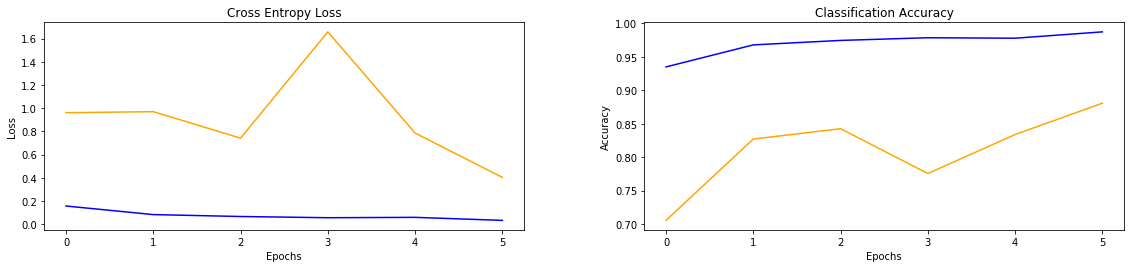

<Figure size 432x288 with 0 Axes>

In [18]:
from tensorflow.keras.utils import multi_gpu_model
#for y in [1,2,3,4,5,6,7,9,14]:
for y in [6]:
    try:
        location="BestWeights_epoch"+str(y)+ ".hdf5"
        checkpointer = ModelCheckpoint(location, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        final_location=[]
        location=[]
        model= Sequential()
        model.add(base_model)
    # model.add(Conv2D(512, (3, 3), activation = 'relu'))

        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        #model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        #model.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-04))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(0.40))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        #model.load_weights("../../ResNet50 Weights/ResNet50final11.hdf5")

    # model.add(Conv2D(512, (3, 3), activation = 'relu'))



        parallel_model = multi_gpu_model(model, gpus=2)
        parallel_model.compile(loss='binary_crossentropy',
                               optimizer=Adam(lr=0.001),metrics=["accuracy"])
    #model.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])
        history_model=parallel_model.fit_generator(generator=train_data,
                                steps_per_epoch=train_data.samples//train_data.batch_size,
                                validation_data=val_data,
                                verbose=1,
                                validation_steps=val_data.samples//val_data.batch_size,
                                epochs=y,callbacks=[learning_rate_reduction,es,checkpointer])

        model.save("NasNet"+str(y)+".hdf5")
        summarize_diagnostics(history_model,y)
        loss=history_model.history['loss']
        acc=history_model.history['acc']
        valacc=history_model.history['val_acc']
        valloss=history_model.history['val_loss']
        location = [y,loss,acc,valacc, valloss]
        final_location.append(location)
        save1 = pd.DataFrame(final_location,columns=['epochs','loss','acc','valacc','valloss'])
        save1.to_csv('NasNet'+str(y)+'.csv')
    except Exception as e: 
        print(e)
        continue